In [3]:
 limport os
import sagemaker

from sagemaker.xgboost import XGBoost
from sagemaker import get_execution_role

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


CREATE FOLDER TO SAVE TRAINING CODE

In [4]:
os.makedirs("training_code_05", exist_ok=True) # Create folder for training code

CREATE TRAINING ENTRY POINT

The hyperparameters are passed as command line arguments.
i.e.:
If we pass following hyparameters:

hyperparameters = {
    'max_depth': 5,
    'n_estimators': 10,
    'learning_rate': 0.1,
    'objective': 'binary:logistic',
}

Then sagemaker does following thing:

python train.py --max_depth 5 --n_estimators 100 --learning_rate 0.1 --objective binary:logistic

In order to read the command line arguments one must use argparse library.

parser = argparse.ArgumentParser()  # Initialisation

parser.add_argument('--max_depth', type=int, default=5) # // Ensure that hyperparameter has proper type and default value in case it is not provided

args = parser.parse_args() # Parse arguments

args.max_depth # Access

In [10]:
%%writefile training_code_05/train.py

from __future__ import print_function

import argparse
import joblib
import os
import pandas as pd
import xgboost as xgb

if __name__ == '__main__':
    parser = argparse.ArgumentParser()

    # Hyperparameters
    parser.add_argument('--max_depth', type=int, default=5)
    parser.add_argument('--n_estimators', type=int, default=100)
    parser.add_argument('--learning_rate', type=float, default=0.1)
    parser.add_argument('--objective', type=str, default='binary:logistic')

    args = parser.parse_args()

    model_dir = os.environ['SM_MODEL_DIR'] # Folder where model must be saved
    train_dir = os.environ['SM_CHANNEL_TRAIN'] # Folder where train data is stored

    # Lets assume there is only one training file
    train_file_name = os.listdir(train_dir)[0]
    train_file_path = os.path.join(train_dir, train_file_name)
    train_data = pd.read_csv(train_file_path, header=None, engine="python")
    
    # Separate features and labels
    train_y = train_data.iloc[:, 0]
    train_X = train_data.iloc[:, 1:]  

    # Train the model
    clf = xgb.XGBClassifier(
        max_depth=args.max_depth,
        n_estimators=args.n_estimators,
        learning_rate=args.learning_rate,
        objective=args.objective)
    clf.fit(train_X, train_y, eval_set=[(train_X, train_y)], eval_metric="logloss", early_stopping_rounds=10, verbose=True)

    # Save the model
    clf.get_booster().save_model(os.path.join(model_dir, "model.xgb"))

Overwriting training_code_05/train.py


CREATE NECCESSARY OBJECTS

In [11]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()

CREATE ESTIMATOR OBJECT

In [12]:
hyperparameters = {
    'max_depth': 3,
    'n_estimators': 8,
    'learning_rate': 0.25,
    'objective': 'binary:logistic',  # example objective for a binary classification task
}

xgboost = XGBoost(
    entry_point='train.py', # The file with the training code
    source_dir='training_code_05', # The folder with the training code
    hyperparameters=hyperparameters, # Hyperparameters for the model
    framework_version='1.3-1', # Version of XGBoost which will be used
    instance_type='ml.m5.large', # Instance type that will be used
    instance_count=1, # Number of instances to train
    role=role, # Role that will be used during execution
    sagemaker_session=sagemaker_session, 
    base_job_name='xgboost-05' # Name of the training job. Timestamp will be added as suffix
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.


FIT THE MODEL
- The fit function have one required parameter in the form of a dictionary.
- The key represents the "channel" of the data. Typically it is train, test, valid. The names can be arbitrary.
- The value contains path to S3 folder that contains the data

The data from all channels will be copied to the training instance.

To obtain LOCAL path to the data one should use os.environ['SM_CHANNEL_CHANNEL'] and replace CHANNEL by actual channel name

Example:

If we specify following dictionary {"train": "s3://sagemaker-bucket-ds/training-jobs/data/train/"} then in the training script the path to the training data is in the object os.environ['SM_CHANNEL_TRAIN']


In [13]:
xgboost.fit({"train": "s3://sagemaker-bucket-ds/training-jobs/data/train/"})

INFO:sagemaker:Creating training-job with name: xgboost-05-2024-06-27-08-10-36-645


2024-06-27 08:10:37 Starting - Starting the training job...
2024-06-27 08:10:53 Starting - Preparing the instances for training...
2024-06-27 08:11:18 Downloading - Downloading input data...
2024-06-27 08:11:57 Downloading - Downloading the training image.....[2024-06-27 08:12:43.482 ip-10-0-225-13.eu-west-1.compute.internal:6 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-06-27 08:12:43.513 ip-10-0-225-13.eu-west-1.compute.internal:6 INFO profiler_config_parser.py:111] User has disabled profiler.
[2024-06-27:08:12:43:INFO] Imported framework sagemaker_xgboost_container.training
[2024-06-27:08:12:43:INFO] No GPUs detected (normal if no gpus installed)
[2024-06-27:08:12:43:INFO] Invoking user training script.
[2024-06-27:08:12:43:INFO] Module train does not provide a setup.py. 
Generating setup.py
[2024-06-27:08:12:43:INFO] Generating setup.cfg
[2024-06-27:08:12:43:INFO] Generating MANIFEST.in
[2024-06-27:08:12:43:INFO] Installing module with the following command:
/minicon

We can see hyperparameters in the training job
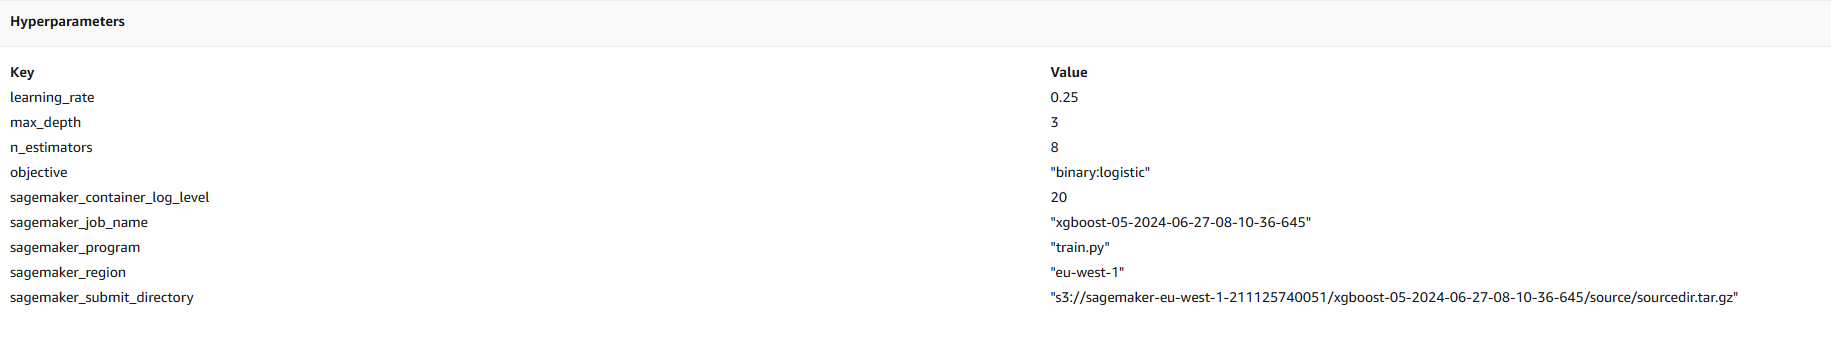